In [ ]:
import pandas as pd
file_path = "/kaggle/input/electroscope-model-just-noimages-studentid1-xlsx/Electroscope_model_just_noimages_studentID(1).xlsx"
df = pd.read_excel(file_path, sheet_name="Original doc with scores")

In [ ]:
df_cleaned = df[df["Justification"].notna() & (df["Justification"].str.strip() != "")]
print(f"{len(df) - len(df_cleaned)}")
print(len(df))

128
1151


In [ ]:
df = df_cleaned

In [ ]:
import pandas as pd
import nltk
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.utils import shuffle

# --------------------
# 1. Setup
# --------------------
nltk.download('punkt')

MODEL_PATH = "allenai/scibert_scivocab_uncased"
CATEGORY_COLS = [f"Category {i}" for i in range(14, 22)]
MIN_UNIT_LEN = 5  # Min words in a unit
THRESHOLD = 0.5   # Multi-label prediction threshold
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
model.eval()

def acquire_labels_multilabel(text):
    """Predict multi-label categories for the given text."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.sigmoid(logits).squeeze().cpu().numpy()
    return (probs >= THRESHOLD).astype(int)

# --------------------
# 3. Extract Units (EASE Step 1)
# --------------------
def extract_units_from_text(text):
    if pd.isna(text) or len(str(text).strip()) < 15:
        return []
    sentences = nltk.sent_tokenize(text)
    units = [s.strip() for s in sentences if len(s.split()) >= MIN_UNIT_LEN]
    return units

# --------------------
# 4. Augmentation (Full EASE)
# --------------------
def augment_categories_14_21(df):
    print("Starting EASE data augmentation (multi-label)...")

    # Filter rows with justification & at least one non-null category
    df_clean = df.dropna(subset=["Justification"]).copy()
    df_clean = df_clean[df_clean[CATEGORY_COLS].notna().any(axis=1)]

    print(f"Original dataset size: {len(df)}")
    print(f"Filtered dataset size: {len(df_clean)}")

    augmented_rows =[]

    for _, row in df_clean.iterrows():
        units = extract_units_from_text(row["Justification"])
        for unit in units:
            # Predict labels using fine-tuned model
            predicted_labels = acquire_labels_multilabel(unit)

            # Create augmented row
            new_row = row.copy()
            new_row["Justification"] = unit
            for col, label in zip(CATEGORY_COLS, predicted_labels):
                new_row[col] = label

            augmented_rows.append(new_row)

    # Sift: limit over-augmentation
    if len(augmented_rows) > len(df_clean) * 2:
        augmented_rows = shuffle(augmented_rows, random_state=42)[:len(df_clean) * 2]

    augmented_df = pd.DataFrame(augmented_rows)
    merged_df = pd.concat([df_clean, augmented_df], ignore_index=True)

    print(f"Generated {len(augmented_df)} augmented samples")
    print(f"Merged dataset size: {len(merged_df)}")

    augmented_df.to_csv("generated_augmented_data.csv", index=False)
    merged_df.to_csv("merged_dataset.csv", index=False)

    print("Saved:")
    print("- generated_augmented_data.csv (only augmented)")
    print("- merged_dataset.csv (original + augmented)")

    return augmented_df, merged_df

# --------------------
# 5. Run
# --------------------
generated_only, merged_data = augment_categories_14_21(df)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

2025-08-09 21:26:00.291146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754774760.589046      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754774760.668371      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Starting EASE data augmentation (multi-label)...
Original dataset size: 1023
Filtered dataset size: 1023
Generated 1287 augmented samples
Merged dataset size: 2310
Saved:
- generated_augmented_data.csv (only augmented)
- merged_dataset.csv (original + augmented)


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

def evaluate_dataset_with_scibert(df, dataset_name="Dataset"):
    """
    Evaluate a dataset using SciBERT for Categories 14-21

    Args:
        df: DataFrame with 'Justification' column and Category 14-21 columns OR file path string
        dataset_name: Name for display purposes
    """
    print(f"\n{'='*60}")
    print(f"SciBERT Evaluation on {dataset_name}")
    print(f"{'='*60}")

    # --------------------- 1. Load Data if needed ---------------------
    # Check if df is a file path string
    if isinstance(df, str):
        print(f"Loading dataset from: {df}")
        df = pd.read_csv(df)
        print(f"Dataset loaded successfully!")

    # --------------------- 2. Prepare Data ---------------------
    category_cols = [f"Category {i}" for i in range(14, 22)]

    # Use Justification column for SciBERT evaluation
    X_texts = df["Justification"].fillna("").astype(str).tolist()
    Y = df[category_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).values

    print(f"Dataset size: {len(df)}")
    print(f"Categories evaluated: {category_cols}")

    # Check for empty dataset
    if len(X_texts) == 0:
        print(f"Warning: {dataset_name} is empty!")
        return pd.DataFrame()

    # --------------------- 2. Split (20/80) Train/Val ---------------------
    X_train, X_val, Y_train, Y_val = train_test_split(X_texts, Y, test_size=0.2, random_state=42)

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")

    # --------------------- 3. Custom Dataset ---------------------
    class MultiLabelDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=512):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt')
            item = {key: val.squeeze(0) for key, val in encoding.items()}
            item["labels"] = torch.tensor(label, dtype=torch.float)
            return item

    # --------------------- 4. Load SciBERT ---------------------
    model_name = "allenai/scibert_scivocab_uncased"

    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(
        model_name,num_labels=len(category_cols),
        problem_type="multi_label_classification")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    # --------------------- 5. DataLoaders ---------------------
    batch_size = 8

    train_dataset = MultiLabelDataset(X_train, Y_train, tokenizer)
    val_dataset = MultiLabelDataset(X_val, Y_val, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # --------------------- 6. Optimizer & Loss ---------------------
    optimizer = AdamW(model.parameters(), lr=2e-5)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # --------------------- 7. Training Loop ---------------------
    epochs = 5
    print(f"\nTraining for {epochs} epochs...")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} - Train Loss: {train_loss / len(train_loader):.4f}")

    # --------------------- 8. Evaluation ---------------------
    print("Evaluating model...")
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).int()

            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

    Y_pred = torch.cat(all_preds).numpy()
    Y_prob = torch.cat(all_probs).numpy()
    Y_true = torch.cat(all_labels).numpy()

    # --------------------- 9. Metrics ---------------------
    results = []
    for i, cat in enumerate(category_cols):
        acc = accuracy_score(Y_true[:, i], Y_pred[:, i])
        prec = precision_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        rec = recall_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        f1 = f1_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        results.append([cat, acc, prec, rec, f1])

    results_df = pd.DataFrame(results, columns=["Category", "Accuracy", "Precision", "Recall", "F1 Score"])
    results_df["Dataset"] = dataset_name  # Add dataset identifier

    print(f"\nSciBERT Evaluation Results for {dataset_name}:")
    print(results_df[["Category", "Accuracy", "Precision", "Recall", "F1 Score"]])

    # Clear GPU memory
    del model, optimizer, train_dataset, val_dataset
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return results_df

results = evaluate_dataset_with_scibert("/kaggle/working/merged_dataset.csv", "Merged Dataset")


SciBERT Evaluation on Merged Dataset
Loading dataset from: /kaggle/working/merged_dataset.csv
Dataset loaded successfully!
Dataset size: 2310
Categories evaluated: ['Category 14', 'Category 15', 'Category 16', 'Category 17', 'Category 18', 'Category 19', 'Category 20', 'Category 21']
Training samples: 1848
Validation samples: 462


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda

Training for 5 epochs...


Epoch 1 - Train Loss: 0.3298


Epoch 2 - Train Loss: 0.2245


Epoch 3 - Train Loss: 0.1701


Epoch 4 - Train Loss: 0.1296


Epoch 5 - Train Loss: 0.1054
Evaluating model...


Evaluating: 100%|██████████| 58/58 [00:14<00:00,  3.89it/s]


SciBERT Evaluation Results for Merged Dataset:
      Category  Accuracy  Precision    Recall  F1 Score
0  Category 14  0.846320   0.500000  0.338028  0.403361
1  Category 15  0.909091   0.357143  0.131579  0.192308
2  Category 16  0.922078   0.831169  0.735632  0.780488
3  Category 17  0.952381   0.966667  0.580000  0.725000
4  Category 18  0.974026   0.888889  0.727273  0.800000
5  Category 19  0.980519   0.850000  0.918919  0.883117
6  Category 20  0.976190   0.951456  0.942308  0.946860
7  Category 21  0.939394   0.694118  0.967213  0.808219


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

def evaluate_dataset_with_scibert(df, dataset_name="Dataset"):
    """
    Evaluate a dataset using SciBERT for Categories 14-21

    Args:
        df: DataFrame with 'Justification' column and Category 14-21 columns OR file path string
        dataset_name: Name for display purposes
    """
    print(f"\n{'='*60}")
    print(f"SciBERT Evaluation on {dataset_name}")
    print(f"{'='*60}")

    # --------------------- 1. Load Data if needed ---------------------
    # Check if df is a file path string
    if isinstance(df, str):
        print(f"Loading dataset from: {df}")
        df = pd.read_csv(df)
        print(f"Dataset loaded successfully!")

    # --------------------- 2. Prepare Data ---------------------
    category_cols = [f"Category {i}" for i in range(14, 22)]

    # Use Justification column for SciBERT evaluation
    X_texts = df["Justification"].fillna("").astype(str).tolist()
    Y = df[category_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).values

    print(f"Dataset size: {len(df)}")
    print(f"Categories evaluated: {category_cols}")

    # Check for empty dataset
    if len(X_texts) == 0:
        print(f"Warning: {dataset_name} is empty!")
        return pd.DataFrame()

    # --------------------- 2. Split (20/80) Train/Val ---------------------
    X_train, X_val, Y_train, Y_val = train_test_split(X_texts, Y, test_size=0.2, random_state=42)

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")

    # --------------------- 3. Custom Dataset ---------------------
    class MultiLabelDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=512):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )
            item = {key: val.squeeze(0) for key, val in encoding.items()}
            item["labels"] = torch.tensor(label, dtype=torch.float)
            return item

    # --------------------- 4. Load SciBERT ---------------------
    model_name = "allenai/scibert_scivocab_uncased"

    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(
        model_name,num_labels=len(category_cols),
        problem_type="multi_label_classification")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    # --------------------- 5. DataLoaders ---------------------
    batch_size = 8

    train_dataset = MultiLabelDataset(X_train, Y_train, tokenizer)
    val_dataset = MultiLabelDataset(X_val, Y_val, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # --------------------- 6. Optimizer & Loss ---------------------
    optimizer = AdamW(model.parameters(), lr=2e-5)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # --------------------- 7. Training Loop ---------------------
    epochs = 5
    print(f"\nTraining for {epochs} epochs...")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} - Train Loss: {train_loss / len(train_loader):.4f}")

    # --------------------- 8. Evaluation ---------------------
    print("Evaluating model...")
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).int()

            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

    Y_pred = torch.cat(all_preds).numpy()
    Y_prob = torch.cat(all_probs).numpy()
    Y_true = torch.cat(all_labels).numpy()

    # --------------------- 9. Metrics ---------------------
    results = []
    for i, cat in enumerate(category_cols):
        acc = accuracy_score(Y_true[:, i], Y_pred[:, i])
        prec = precision_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        rec = recall_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        f1 = f1_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        results.append([cat, acc, prec, rec, f1])

    results_df = pd.DataFrame(results, columns=["Category", "Accuracy", "Precision", "Recall", "F1 Score"])
    results_df["Dataset"] = dataset_name  # Add dataset identifier

    print(f"\nSciBERT Evaluation Results for {dataset_name}:")
    print(results_df[["Category", "Accuracy", "Precision", "Recall", "F1 Score"]])

    # Clear GPU memory
    del model, optimizer, train_dataset, val_dataset
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return results_df

results = evaluate_dataset_with_scibert("/kaggle/working/generated_augmented_data.csv", "Generated Dataset")


SciBERT Evaluation on Generated Dataset
Loading dataset from: /kaggle/working/generated_augmented_data.csv
Dataset loaded successfully!
Dataset size: 1287
Categories evaluated: ['Category 14', 'Category 15', 'Category 16', 'Category 17', 'Category 18', 'Category 19', 'Category 20', 'Category 21']
Training samples: 1029
Validation samples: 258


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda

Training for 5 epochs...


Epoch 1 - Train Loss: 0.3249


Epoch 2 - Train Loss: 0.2272


Epoch 3 - Train Loss: 0.1743


Epoch 4 - Train Loss: 0.1391


Epoch 5 - Train Loss: 0.1043
Evaluating model...


Evaluating: 100%|██████████| 33/33 [00:08<00:00,  4.02it/s]


SciBERT Evaluation Results for Generated Dataset:
      Category  Accuracy  Precision    Recall  F1 Score
0  Category 14  0.996124   1.000000  0.500000  0.666667
1  Category 15  0.957364   0.750000  0.230769  0.352941
2  Category 16  0.810078   0.666667  0.579710  0.620155
3  Category 17  0.891473   0.720000  0.461538  0.562500
4  Category 18  0.930233   0.588235  0.476190  0.526316
5  Category 19  0.922481   0.520000  0.619048  0.565217
6  Category 20  0.934109   0.836735  0.820000  0.828283
7  Category 21  0.864341   0.636364  0.184211  0.285714


Starting SciBERT evaluation...
Initial → Generated → Merged datasets

SciBERT Evaluation on Initial Dataset
Dataset size: 1023
Categories evaluated: ['Category 14', 'Category 15', 'Category 16', 'Category 17', 'Category 18', 'Category 19', 'Category 20', 'Category 21']
Training samples: 818
Validation samples: 205


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda

Training for 5 epochs...


Epoch 1 - Train Loss: 0.3903


Epoch 2 - Train Loss: 0.2442


Epoch 3 - Train Loss: 0.1737


Epoch 4 - Train Loss: 0.1327


Epoch 5 - Train Loss: 0.1003
Evaluating model...


Evaluating: 100%|██████████| 26/26 [00:06<00:00,  3.99it/s]



SciBERT Evaluation Results for Initial Dataset:
      Category  Accuracy  Precision    Recall  F1 Score
0  Category 14  0.892683   0.759036  0.969231  0.851351
1  Category 15  0.960976   0.766667  0.958333  0.851852
2  Category 16  0.878049   0.647059  0.825000  0.725275
3  Category 17  0.931707   0.000000  0.000000  0.000000
4  Category 18  0.960976   1.000000  0.272727  0.428571
5  Category 19  0.941463   0.545455  0.461538  0.500000
6  Category 20  0.956098   0.897959  0.916667  0.907216
7  Category 21  0.902439   0.789474  0.483871  0.600000

SciBERT Evaluation on Generated Dataset
Dataset size: 1287
Categories evaluated: ['Category 14', 'Category 15', 'Category 16', 'Category 17', 'Category 18', 'Category 19', 'Category 20', 'Category 21']
Training samples: 1029
Validation samples: 258


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda

Training for 5 epochs...


Epoch 1 - Train Loss: 0.3214


Epoch 2 - Train Loss: 0.2255


Epoch 3 - Train Loss: 0.1803


Epoch 4 - Train Loss: 0.1430


Epoch 5 - Train Loss: 0.1053
Evaluating model...


Evaluating: 100%|██████████| 33/33 [00:08<00:00,  4.03it/s]



SciBERT Evaluation Results for Generated Dataset:
      Category  Accuracy  Precision    Recall  F1 Score
0  Category 14  0.996124   1.000000  0.500000  0.666667
1  Category 15  0.961240   1.000000  0.230769  0.375000
2  Category 16  0.759690   0.534653  0.782609  0.635294
3  Category 17  0.891473   0.720000  0.461538  0.562500
4  Category 18  0.953488   0.764706  0.619048  0.684211
5  Category 19  0.934109   0.600000  0.571429  0.585366
6  Category 20  0.949612   0.849057  0.900000  0.873786
7  Category 21  0.875969   1.000000  0.157895  0.272727

SciBERT Evaluation on Merged Dataset
Dataset size: 2310
Categories evaluated: ['Category 14', 'Category 15', 'Category 16', 'Category 17', 'Category 18', 'Category 19', 'Category 20', 'Category 21']
Training samples: 1848
Validation samples: 462


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda

Training for 5 epochs...


Epoch 1 - Train Loss: 0.3270


Epoch 2 - Train Loss: 0.2129


Epoch 3 - Train Loss: 0.1597


Epoch 4 - Train Loss: 0.1212


Epoch 5 - Train Loss: 0.0977
Evaluating model...


Evaluating: 100%|██████████| 58/58 [00:14<00:00,  3.96it/s]



SciBERT Evaluation Results for Merged Dataset:
      Category  Accuracy  Precision    Recall  F1 Score
0  Category 14  0.824675   0.421875  0.380282  0.400000
1  Category 15  0.885281   0.258065  0.210526  0.231884
2  Category 16  0.906926   0.750000  0.758621  0.754286
3  Category 17  0.932900   0.672727  0.740000  0.704762
4  Category 18  0.967532   0.750000  0.818182  0.782609
5  Category 19  0.974026   0.903226  0.756757  0.823529
6  Category 20  0.969697   0.950000  0.913462  0.931373
7  Category 21  0.932900   0.666667  0.983607  0.794702


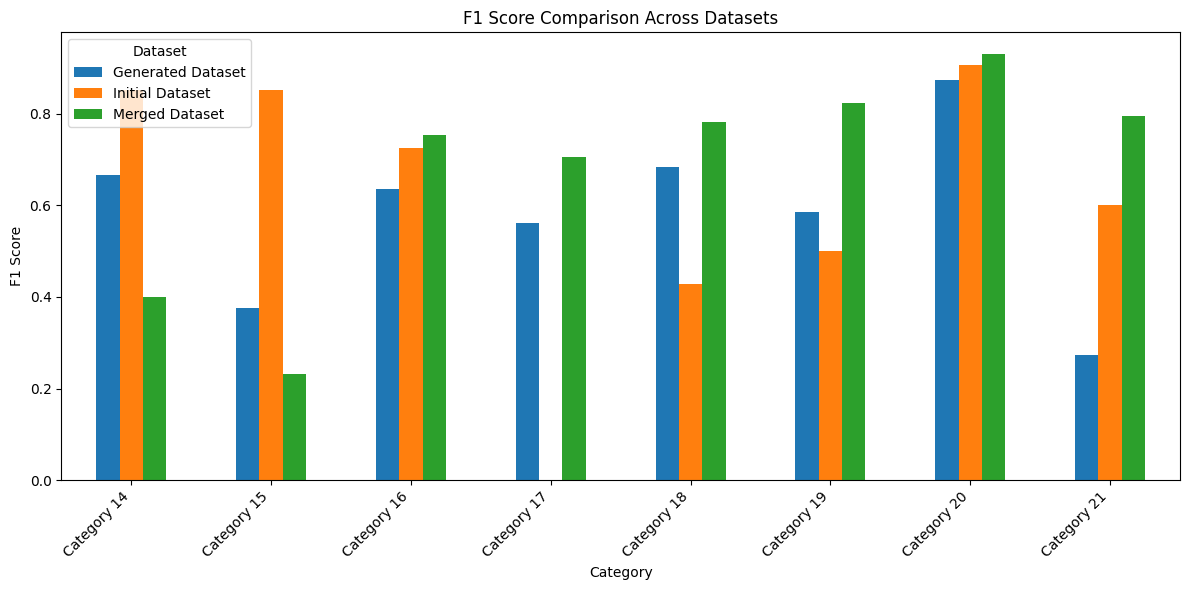

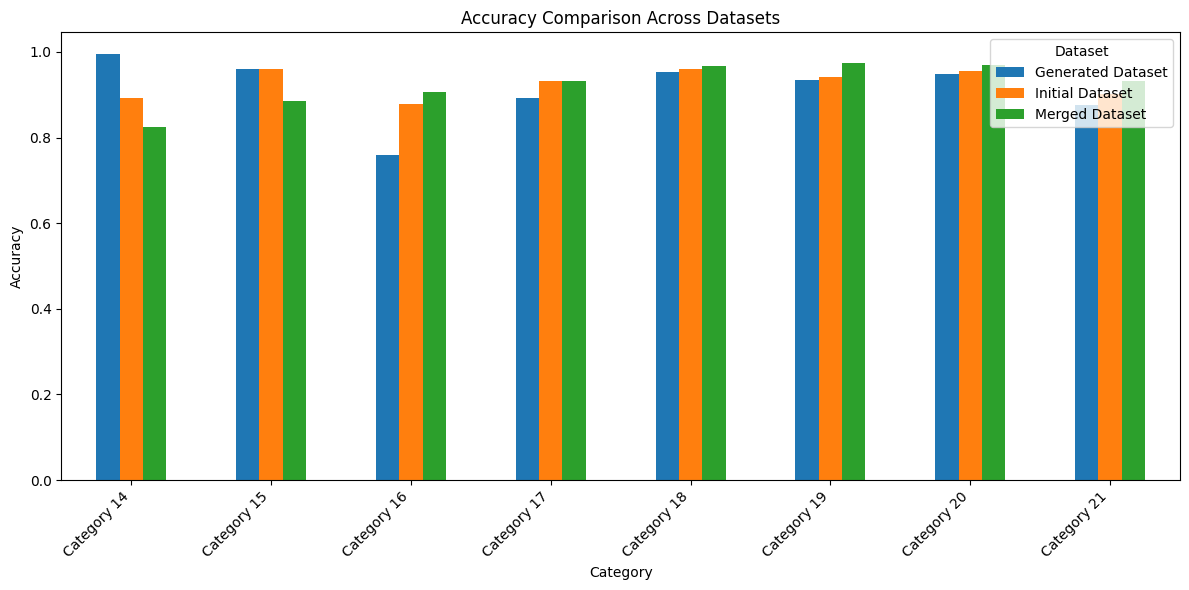


Results saved to 'scibert_evaluation_results.csv'
Graphs saved as 'f1_score_comparison.png' and 'accuracy_comparison.png'


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

def evaluate_dataset_with_scibert(df, dataset_name="Dataset"):
    """
    Evaluate a dataset using SciBERT for Categories 14-21

    Args:
        df: DataFrame with 'Justification' column and Category 14-21 columns OR file path string
        dataset_name: Name for display purposes
    """
    print(f"\n{'='*60}")
    print(f"SciBERT Evaluation on {dataset_name}")
    print(f"{'='*60}")

    # --------------------- 1. Load Data if needed ---------------------
    # Check if df is a file path string
    if isinstance(df, str):
        print(f"Loading dataset from: {df}")
        df = pd.read_csv(df)
        print(f"Dataset loaded successfully!")

    # --------------------- 2. Prepare Data ---------------------
    category_cols = [f"Category {i}" for i in range(14, 22)]

    # Use Justification column for SciBERT evaluation
    X_texts = df["Justification"].fillna("").astype(str).tolist()
    Y = df[category_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).values

    print(f"Dataset size: {len(df)}")
    print(f"Categories evaluated: {category_cols}")

    # Check for empty dataset
    if len(X_texts) == 0:
        print(f"Warning: {dataset_name} is empty!")
        return pd.DataFrame()

    # --------------------- 2. Split (20/80) Train/Val ---------------------
    X_train, X_val, Y_train, Y_val = train_test_split(X_texts, Y, test_size=0.2, random_state=42)

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")

    # --------------------- 3. Custom Dataset ---------------------
    class MultiLabelDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=512):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )
            item = {key: val.squeeze(0) for key, val in encoding.items()}
            item["labels"] = torch.tensor(label, dtype=torch.float)
            return item

    # --------------------- 4. Load SciBERT ---------------------
    model_name = "allenai/scibert_scivocab_uncased"

    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(category_cols),
        problem_type="multi_label_classification")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    # --------------------- 5. DataLoaders ---------------------
    batch_size = 8

    train_dataset = MultiLabelDataset(X_train, Y_train, tokenizer)
    val_dataset = MultiLabelDataset(X_val, Y_val, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # --------------------- 6. Optimizer & Loss ---------------------
    optimizer = AdamW(model.parameters(), lr=2e-5)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # --------------------- 7. Training Loop ---------------------
    epochs = 5
    print(f"\nTraining for {epochs} epochs...")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} - Train Loss: {train_loss / len(train_loader):.4f}")

    # --------------------- 8. Evaluation ---------------------
    print("Evaluating model...")
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).int()

            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

    Y_pred = torch.cat(all_preds).numpy()
    Y_prob = torch.cat(all_probs).numpy()
    Y_true = torch.cat(all_labels).numpy()

    # --------------------- 9. Metrics ---------------------
    results = []
    for i, cat in enumerate(category_cols):
        acc = accuracy_score(Y_true[:, i], Y_pred[:, i])
        prec = precision_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        rec = recall_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        f1 = f1_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        results.append([cat, acc, prec, rec, f1])

    results_df = pd.DataFrame(results, columns=["Category", "Accuracy", "Precision", "Recall", "F1 Score"])
    results_df["Dataset"] = dataset_name  # Add dataset identifier

    print(f"\nSciBERT Evaluation Results for {dataset_name}:")
    print(results_df[["Category", "Accuracy", "Precision", "Recall", "F1 Score"]])

    # Clear GPU memory
    del model, optimizer, train_dataset, val_dataset
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return results_df

import matplotlib.pyplot as plt
def compare_all_datasets(initial_df, generated_df, merged_df):
    """
    Compare SciBERT performance across all three datasets and plot graphs
    """
    print("Starting SciBERT evaluation...")
    print("Initial → Generated → Merged datasets")

    all_results = []

    # Evaluate Initial Dataset
    if len(initial_df) > 0:
        initial_results = evaluate_dataset_with_scibert(initial_df, "Initial Dataset")
        all_results.append(initial_results)

    # Evaluate Generated Dataset
    if len(generated_df) > 0:
        generated_results = evaluate_dataset_with_scibert(generated_df, "Generated Dataset")
        all_results.append(generated_results)

    # Evaluate Merged Dataset
    if len(merged_df) > 0:
        merged_results = evaluate_dataset_with_scibert(merged_df, "Merged Dataset")
        all_results.append(merged_results)

    # Combine all results for comparison
    if all_results:
        comparison_df = pd.concat(all_results, ignore_index=True)

        # Pivot for easier comparison
        comparison_pivot = comparison_df.pivot_table(
            index='Category',
            columns='Dataset',
            values=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
            aggfunc='first')

        # Plot F1 score comparison
        if 'F1 Score' in comparison_pivot.columns.levels[0]:
            f1_scores = comparison_pivot['F1 Score']
            f1_scores.plot(kind='bar', figsize=(12,6))
            plt.title("F1 Score Comparison Across Datasets")
            plt.ylabel("F1 Score")
            plt.xticks(rotation=45, ha='right')
            plt.legend(title="Dataset")
            plt.tight_layout()
            plt.savefig("f1_score_comparison.png")
            plt.show()

        # Plot Accuracy comparison
        if 'Accuracy' in comparison_pivot.columns.levels[0]:
            acc_scores = comparison_pivot['Accuracy']
            acc_scores.plot(kind='bar', figsize=(12,6))
            plt.title("Accuracy Comparison Across Datasets")
            plt.ylabel("Accuracy")
            plt.xticks(rotation=45, ha='right')
            plt.legend(title="Dataset")
            plt.tight_layout()
            plt.savefig("accuracy_comparison.png")
            plt.show()

        # Save results table
        comparison_df.to_csv('scibert_evaluation_results.csv', index=False)
        print(f"\nResults saved to 'scibert_evaluation_results.csv'")
        print("Graphs saved as 'f1_score_comparison.png' and 'accuracy_comparison.png'")

        return comparison_df

    return pd.DataFrame()

generated_df = pd.read_csv("/kaggle/working/generated_augmented_data.csv")
merged_df = pd.read_csv("/kaggle/working/merged_dataset.csv")
comparison = compare_all_datasets(df, generated_df, merged_df)

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

def evaluate_dataset_with_scibert(df, dataset_name="Dataset"):
    """
    Evaluate a dataset using SciBERT for Categories 14-21

    Args:
        df: DataFrame with 'Justification' column and Category 14-21 columns
        dataset_name: Name for display purposes
    """
    print(f"\n{'='*60}")
    print(f"SciBERT Evaluation on {dataset_name}")
    print(f"{'='*60}")

    # --------------------- 1. Prepare Data ---------------------
    category_cols = [f"Category {i}" for i in range(14, 22)]

    # Use Justification column for SciBERT evaluation
    X_texts = df["Justification"].fillna("").astype(str).tolist()
    Y = df[category_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).values

    print(f"Dataset size: {len(df)}")
    print(f"Categories evaluated: {category_cols}")

    # Check for empty dataset
    if len(X_texts) == 0:
        print(f"Warning: {dataset_name} is empty!")
        return pd.DataFrame()

    # --------------------- 2. Split (20/80) Train/Val ---------------------
    X_train, X_val, Y_train, Y_val = train_test_split(X_texts, Y, test_size=0.2, random_state=42)

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")

    # --------------------- 3. Custom Dataset ---------------------
    class MultiLabelDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=512):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )
            item = {key: val.squeeze(0) for key, val in encoding.items()}
            item["labels"] = torch.tensor(label, dtype=torch.float)
            return item

    # --------------------- 4. Load SciBERT ---------------------
    model_name = "allenai/scibert_scivocab_uncased"

    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(category_cols),
        problem_type="multi_label_classification"
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    # --------------------- 5. DataLoaders ---------------------
    batch_size = 8

    train_dataset = MultiLabelDataset(X_train, Y_train, tokenizer)
    val_dataset = MultiLabelDataset(X_val, Y_val, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # --------------------- 6. Optimizer & Loss ---------------------
    optimizer = AdamW(model.parameters(), lr=2e-5)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # --------------------- 7. Training Loop ---------------------
    epochs = 5
    print(f"\nTraining for {epochs} epochs...")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} - Train Loss: {train_loss / len(train_loader):.4f}")

    # --------------------- 8. Evaluation ---------------------
    print("Evaluating model...")
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).int()

            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

    Y_pred = torch.cat(all_preds).numpy()
    Y_prob = torch.cat(all_probs).numpy()
    Y_true = torch.cat(all_labels).numpy()

    # --------------------- 9. Metrics ---------------------
    results = []
    for i, cat in enumerate(category_cols):
        acc = accuracy_score(Y_true[:, i], Y_pred[:, i])
        prec = precision_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        rec = recall_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        f1 = f1_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        results.append([cat, acc, prec, rec, f1])

    results_df = pd.DataFrame(results, columns=["Category", "Accuracy", "Precision", "Recall", "F1 Score"])
    results_df["Dataset"] = dataset_name  # Add dataset identifier

    print(f"\nSciBERT Evaluation Results for {dataset_name}:")
    print(results_df[["Category", "Accuracy", "Precision", "Recall", "F1 Score"]])

    # Clear GPU memory
    del model, optimizer, train_dataset, val_dataset
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return results_df

def compare_all_datasets(initial_df, generated_df, merged_df):
    """
    Compare SciBERT performance across all three datasets
    """
    print("Starting comprehensive SciBERT evaluation...")
    print("This will evaluate: Initial → Generated → Merged datasets")

    all_results = []

    # Evaluate Initial Dataset
    if len(initial_df) > 0:
        initial_results = evaluate_dataset_with_scibert(initial_df, "Initial Dataset")
        all_results.append(initial_results)

    # Evaluate Generated Dataset
    if len(generated_df) > 0:
        generated_results = evaluate_dataset_with_scibert(generated_df, "Generated Dataset")
        all_results.append(generated_results)

    # Evaluate Merged Dataset
    if len(merged_df) > 0:
        merged_results = evaluate_dataset_with_scibert(merged_df, "Merged Dataset")
        all_results.append(merged_results)

    # Combine all results for comparison
    if all_results:
        comparison_df = pd.concat(all_results, ignore_index=True)

        print(f"\n{'='*80}")
        print("COMPREHENSIVE COMPARISON - All Datasets")
        print(f"{'='*80}")

        # Pivot for easier comparison
        comparison_pivot = comparison_df.pivot_table(
            index='Category',
            columns='Dataset',
            values=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
            aggfunc='first'
        )

        print("\nF1 Score Comparison:")
        if 'F1 Score' in comparison_pivot.columns.levels[0]:
            print(comparison_pivot['F1 Score'].round(4))

        print("\nAccuracy Comparison:")
        if 'Accuracy' in comparison_pivot.columns.levels[0]:
            print(comparison_pivot['Accuracy'].round(4))

        # Save comprehensive results
        comparison_df.to_csv('scibert_evaluation_results.csv', index=False)
        print(f"\nResults saved to 'scibert_evaluation_results.csv'")

        return comparison_df

    return pd.DataFrame()


# df = initial_df  # ← CHANGE THIS LINE to switch datasets
results = evaluate_dataset_with_scibert(df, "Initial Dataset")

# initial_df = pd.read_csv('your_initial_dataset.csv')
# generated_df = pd.read_csv('generated_augmented_data.csv')
# merged_df = pd.read_csv('merged_dataset.csv')
# comparison_results = compare_all_datasets(initial_df, generated_df, merged_df)


SciBERT Evaluation on Initial Dataset
Dataset size: 1023
Categories evaluated: ['Category 14', 'Category 15', 'Category 16', 'Category 17', 'Category 18', 'Category 19', 'Category 20', 'Category 21']
Training samples: 818
Validation samples: 205


vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda

Training for 5 epochs...



Epoch 1/5: 100%|██████████| 103/103 [01:18<00:00,  1.57it/s, loss=0.159]
                                                                        

Epoch 1 - Train Loss: 0.3828


Epoch 4 - Train Loss: 0.1323


Epoch 5 - Train Loss: 0.0983
Evaluating model...


Evaluating: 100%|██████████| 26/26 [00:06<00:00,  3.98it/s]



SciBERT Evaluation Results for Initial Dataset:
      Category  Accuracy  Precision    Recall  F1 Score
0  Category 14  0.882927   0.746988  0.953846  0.837838
1  Category 15  0.960976   0.785714  0.916667  0.846154
2  Category 16  0.902439   0.708333  0.850000  0.772727
3  Category 17  0.902439   0.200000  0.142857  0.166667
4  Category 18  0.975610   0.875000  0.636364  0.736842
5  Category 19  0.956098   0.666667  0.615385  0.640000
6  Category 20  0.917073   0.918919  0.708333  0.800000
7  Category 21  0.882927   0.652174  0.483871  0.555556
SciBERT evaluation functions ready!

Usage Options:
1. Single dataset: results = evaluate_dataset_with_scibert(df, 'Dataset Name')
2. Compare all: comparison = compare_all_datasets(initial_df, generated_df, merged_df)

To switch datasets for single evaluation, just change the 'df' variable!


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

def evaluate_dataset_with_scibert(df, dataset_name="Dataset"):
    """
    Evaluate a dataset using SciBERT for Categories 14-21

    Args:
        df: DataFrame with 'Justification' column and Category 14-21 columns OR file path string
        dataset_name: Name for display purposes
    """
    print(f"\n{'='*60}")
    print(f"SciBERT Evaluation on {dataset_name}")
    print(f"{'='*60}")

    # --------------------- 1. Load Data if needed ---------------------
    # Check if df is a file path string
    if isinstance(df, str):
        print(f"Loading dataset from: {df}")
        df = pd.read_csv(df)
        print(f"Dataset loaded successfully!")

    # --------------------- 2. Prepare Data ---------------------
    category_cols = [f"Category {i}" for i in range(14, 22)]

    # Use Justification column for SciBERT evaluation
    X_texts = df["Justification"].fillna("").astype(str).tolist()
    Y = df[category_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).values

    print(f"Dataset size: {len(df)}")
    print(f"Categories evaluated: {category_cols}")

    # Check for empty dataset
    if len(X_texts) == 0:
        print(f"Warning: {dataset_name} is empty!")
        return pd.DataFrame()

    # --------------------- 2. Split (20/80) Train/Val ---------------------
    X_train, X_val, Y_train, Y_val = train_test_split(X_texts, Y, test_size=0.2, random_state=42)

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")

    # --------------------- 3. Custom Dataset ---------------------
    class MultiLabelDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=512):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )
            item = {key: val.squeeze(0) for key, val in encoding.items()}
            item["labels"] = torch.tensor(label, dtype=torch.float)
            return item

    # --------------------- 4. Load SciBERT ---------------------
    model_name = "allenai/scibert_scivocab_uncased"

    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(category_cols),
        problem_type="multi_label_classification"
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    # --------------------- 5. DataLoaders ---------------------
    batch_size = 8

    train_dataset = MultiLabelDataset(X_train, Y_train, tokenizer)
    val_dataset = MultiLabelDataset(X_val, Y_val, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # --------------------- 6. Optimizer & Loss ---------------------
    optimizer = AdamW(model.parameters(), lr=2e-5)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # --------------------- 7. Training Loop ---------------------
    epochs = 5
    print(f"\nTraining for {epochs} epochs...")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} - Train Loss: {train_loss / len(train_loader):.4f}")

    # --------------------- 8. Evaluation ---------------------
    print("Evaluating model...")
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).int()

            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

    Y_pred = torch.cat(all_preds).numpy()
    Y_prob = torch.cat(all_probs).numpy()
    Y_true = torch.cat(all_labels).numpy()

    # --------------------- 9. Metrics ---------------------
    results = []
    for i, cat in enumerate(category_cols):
        acc = accuracy_score(Y_true[:, i], Y_pred[:, i])
        prec = precision_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        rec = recall_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        f1 = f1_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        results.append([cat, acc, prec, rec, f1])

    results_df = pd.DataFrame(results, columns=["Category", "Accuracy", "Precision", "Recall", "F1 Score"])
    results_df["Dataset"] = dataset_name  # Add dataset identifier

    print(f"\nSciBERT Evaluation Results for {dataset_name}:")
    print(results_df[["Category", "Accuracy", "Precision", "Recall", "F1 Score"]])

    # Clear GPU memory
    del model, optimizer, train_dataset, val_dataset
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return results_df

def compare_all_datasets(initial_df, generated_df, merged_df):
    """
    Compare SciBERT performance across all three datasets
    """
    print("Starting comprehensive SciBERT evaluation...")
    print("This will evaluate: Initial → Generated → Merged datasets")

    all_results = []

    # Evaluate Initial Dataset
    if len(initial_df) > 0:
        initial_results = evaluate_dataset_with_scibert(initial_df, "Initial Dataset")
        all_results.append(initial_results)

    # Evaluate Generated Dataset
    if len(generated_df) > 0:
        generated_results = evaluate_dataset_with_scibert(generated_df, "Generated Dataset")
        all_results.append(generated_results)

    # Evaluate Merged Dataset
    if len(merged_df) > 0:
        merged_results = evaluate_dataset_with_scibert(merged_df, "Merged Dataset")
        all_results.append(merged_results)

    # Combine all results for comparison
    if all_results:
        comparison_df = pd.concat(all_results, ignore_index=True)

        print(f"\n{'='*80}")
        print("COMPREHENSIVE COMPARISON - All Datasets")
        print(f"{'='*80}")

        # Pivot for easier comparison
        comparison_pivot = comparison_df.pivot_table(
            index='Category',
            columns='Dataset',
            values=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
            aggfunc='first'
        )

        print("\nF1 Score Comparison:")
        if 'F1 Score' in comparison_pivot.columns.levels[0]:
            print(comparison_pivot['F1 Score'].round(4))

        print("\nAccuracy Comparison:")
        if 'Accuracy' in comparison_pivot.columns.levels[0]:
            print(comparison_pivot['Accuracy'].round(4))

        # Save comprehensive results
        comparison_df.to_csv('scibert_evaluation_results.csv', index=False)
        print(f"\nResults saved to 'scibert_evaluation_results.csv'")

        return comparison_df

    return pd.DataFrame()

results = evaluate_dataset_with_scibert("/kaggle/working/merged_dataset.csv", "Merged Dataset")


SciBERT Evaluation on Merged Dataset
Loading dataset from: /kaggle/working/merged_dataset.csv
Dataset loaded successfully!
Dataset size: 1565
Categories evaluated: ['Category 14', 'Category 15', 'Category 16', 'Category 17', 'Category 18', 'Category 19', 'Category 20', 'Category 21']
Training samples: 1252
Validation samples: 313


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda

Training for 5 epochs...


Epoch 1 - Train Loss: 0.4344


Epoch 2 - Train Loss: 0.3475


Epoch 3 - Train Loss: 0.2888


Epoch 4 - Train Loss: 0.2331


Epoch 5 - Train Loss: 0.1744
Evaluating model...


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  4.00it/s]


SciBERT Evaluation Results for Merged Dataset:
      Category  Accuracy  Precision    Recall  F1 Score
0  Category 14  0.811502   0.604396  0.705128  0.650888
1  Category 15  0.859425   0.542373  0.653061  0.592593
2  Category 16  0.859425   0.483333  0.690476  0.568627
3  Category 17  0.817891   0.480769  0.454545  0.467290
4  Category 18  0.849840   0.475000  0.422222  0.447059
5  Category 19  0.849840   0.479167  0.511111  0.494624
6  Category 20  0.929712   0.770833  0.770833  0.770833
7  Category 21  0.853035   0.653846  0.548387  0.596491
SciBERT evaluation functions ready!

Usage Options:
1. DataFrame: results = evaluate_dataset_with_scibert(df, 'Dataset Name')
2. File path: results = evaluate_dataset_with_scibert('/path/to/file.csv', 'Dataset Name')
3. Compare all: comparison = compare_all_datasets(df1, df2, df3)

Now supports both DataFrames and file paths!


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

def evaluate_dataset_with_scibert(df, dataset_name="Dataset"):
    """
    Evaluate a dataset using SciBERT for Categories 14-21

    Args:
        df: DataFrame with 'Justification' column and Category 14-21 columns OR file path string
        dataset_name: Name for display purposes
    """
    print(f"\n{'='*60}")
    print(f"SciBERT Evaluation on {dataset_name}")
    print(f"{'='*60}")

    # --------------------- 1. Load Data if needed ---------------------
    # Check if df is a file path string
    if isinstance(df, str):
        print(f"Loading dataset from: {df}")
        df = pd.read_csv(df)
        print(f"Dataset loaded successfully!")

    # --------------------- 2. Prepare Data ---------------------
    category_cols = [f"Category {i}" for i in range(14, 22)]

    # Use Justification column for SciBERT evaluation
    X_texts = df["Justification"].fillna("").astype(str).tolist()
    Y = df[category_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).values

    print(f"Dataset size: {len(df)}")
    print(f"Categories evaluated: {category_cols}")

    # Check for empty dataset
    if len(X_texts) == 0:
        print(f"Warning: {dataset_name} is empty!")
        return pd.DataFrame()

    # --------------------- 2. Split (20/80) Train/Val ---------------------
    X_train, X_val, Y_train, Y_val = train_test_split(X_texts, Y, test_size=0.2, random_state=42)

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")

    # --------------------- 3. Custom Dataset ---------------------
    class MultiLabelDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=512):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )
            item = {key: val.squeeze(0) for key, val in encoding.items()}
            item["labels"] = torch.tensor(label, dtype=torch.float)
            return item

    # --------------------- 4. Load SciBERT ---------------------
    model_name = "allenai/scibert_scivocab_uncased"

    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(category_cols),
        problem_type="multi_label_classification"
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    # --------------------- 5. DataLoaders ---------------------
    batch_size = 8

    train_dataset = MultiLabelDataset(X_train, Y_train, tokenizer)
    val_dataset = MultiLabelDataset(X_val, Y_val, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # --------------------- 6. Optimizer & Loss ---------------------
    optimizer = AdamW(model.parameters(), lr=2e-5)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # --------------------- 7. Training Loop ---------------------
    epochs = 5
    print(f"\nTraining for {epochs} epochs...")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} - Train Loss: {train_loss / len(train_loader):.4f}")

    # --------------------- 8. Evaluation ---------------------
    print("Evaluating model...")
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).int()

            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

    Y_pred = torch.cat(all_preds).numpy()
    Y_prob = torch.cat(all_probs).numpy()
    Y_true = torch.cat(all_labels).numpy()

    # --------------------- 9. Metrics ---------------------
    results = []
    for i, cat in enumerate(category_cols):
        acc = accuracy_score(Y_true[:, i], Y_pred[:, i])
        prec = precision_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        rec = recall_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        f1 = f1_score(Y_true[:, i], Y_pred[:, i], zero_division=0)
        results.append([cat, acc, prec, rec, f1])

    results_df = pd.DataFrame(results, columns=["Category", "Accuracy", "Precision", "Recall", "F1 Score"])
    results_df["Dataset"] = dataset_name  # Add dataset identifier

    print(f"\nSciBERT Evaluation Results for {dataset_name}:")
    print(results_df[["Category", "Accuracy", "Precision", "Recall", "F1 Score"]])

    # Clear GPU memory
    del model, optimizer, train_dataset, val_dataset
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return results_df

def compare_all_datasets(initial_df, generated_df, merged_df):
    """
    Compare SciBERT performance across all three datasets
    """
    print("Starting comprehensive SciBERT evaluation...")
    print("This will evaluate: Initial → Generated → Merged datasets")

    all_results = []

    # Evaluate Initial Dataset
    if len(initial_df) > 0:
        initial_results = evaluate_dataset_with_scibert(initial_df, "Initial Dataset")
        all_results.append(initial_results)

    # Evaluate Generated Dataset
    if len(generated_df) > 0:
        generated_results = evaluate_dataset_with_scibert(generated_df, "Generated Dataset")
        all_results.append(generated_results)

    # Evaluate Merged Dataset
    if len(merged_df) > 0:
        merged_results = evaluate_dataset_with_scibert(merged_df, "Merged Dataset")
        all_results.append(merged_results)

    # Combine all results for comparison
    if all_results:
        comparison_df = pd.concat(all_results, ignore_index=True)

        print(f"\n{'='*80}")
        print("COMPREHENSIVE COMPARISON - All Datasets")
        print(f"{'='*80}")

        # Pivot for easier comparison
        comparison_pivot = comparison_df.pivot_table(
            index='Category',
            columns='Dataset',
            values=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
            aggfunc='first'
        )

        print("\nF1 Score Comparison:")
        if 'F1 Score' in comparison_pivot.columns.levels[0]:
            print(comparison_pivot['F1 Score'].round(4))

        print("\nAccuracy Comparison:")
        if 'Accuracy' in comparison_pivot.columns.levels[0]:
            print(comparison_pivot['Accuracy'].round(4))

        # Save comprehensive results
        comparison_df.to_csv('scibert_evaluation_results.csv', index=False)
        print(f"\nResults saved to 'scibert_evaluation_results.csv'")

        return comparison_df

    return pd.DataFrame()

results = evaluate_dataset_with_scibert("/kaggle/working/generated_augmented_data.csv", "Generated Dataset")


SciBERT Evaluation on Generated Dataset
Loading dataset from: /kaggle/working/generated_augmented_data.csv
Dataset loaded successfully!
Dataset size: 542
Categories evaluated: ['Category 14', 'Category 15', 'Category 16', 'Category 17', 'Category 18', 'Category 19', 'Category 20', 'Category 21']
Training samples: 433
Validation samples: 109


vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda

Training for 5 epochs...



Epoch 1/5: 100%|██████████| 55/55 [00:37<00:00,  1.88it/s, loss=0.261]
                                                                      

Epoch 1 - Train Loss: 0.5117


Epoch 2 - Train Loss: 0.4697


Epoch 3 - Train Loss: 0.3784


Epoch 4 - Train Loss: 0.2489


Epoch 5 - Train Loss: 0.2158
Evaluating model...


Evaluating: 100%|██████████| 14/14 [00:03<00:00,  4.27it/s]



SciBERT Evaluation Results for Generated Dataset:
      Category  Accuracy  Precision    Recall  F1 Score
0  Category 14  0.917431   0.500000  0.222222  0.307692
1  Category 15  0.770642   0.541667  0.481481  0.509804
2  Category 16  0.944954   0.000000  0.000000  0.000000
3  Category 17  0.770642   0.541667  0.481481  0.509804
4  Category 18  0.770642   0.541667  0.481481  0.509804
5  Category 19  0.770642   0.541667  0.481481  0.509804
6  Category 20  0.972477   0.000000  0.000000  0.000000
7  Category 21  0.770642   0.541667  0.481481  0.509804
